**Part 1: Problem Context**

**1) What the dataset contains**

The Breast Cancer Wisconsin (Diagnostic) dataset has 569 samples from breast tissue images. Each sample includes 30 numerical features that describe cell characteristics, and the goal is to predict whether the tumor is malignant or benign.

**2)Where it originated**

The dataset comes from the UCI Machine Learning Repository and is available in scikit-learn’s datasets module. It includes features such as the mean, standard error, and worst (largest) values of measurements like radius, texture, perimeter, area, smoothness, and concavity of the cell nuclei.

**3) The classification problem being solved**

The classification problem is to predict whether a tumor is malignant or benign based on these measured features.

**4) Why solving this problem is important**
Solving this problem matters because early and accurate detection helps doctors make faster decisions, avoid unnecessary biopsies, and provide better care for patients.

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, confusion_matrix

In [4]:
# Load data
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name='target')


In [5]:
X.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [6]:
y.head()

,target
0,0
1,0
2,0
3,0
4,0


**EDA**

For exploratory data analysis, I first examined the distribution of the mean radius feature for benign and malignant tumors using KDE plots.

The KDE curves show that malignant tumors tend to have larger mean radius values, while benign tumors are more concentrated at smaller radii, suggesting that mean radius is a strongly discriminative feature.

Next, I computed a correlation heatmap across all 30 features to understand how the predictors relate to each other.

The heatmap reveals strong positive correlations among size-related features such as mean radius, perimeter, and area, as well as among shape and texture features like concavity and compactness.

These patterns suggest that the dataset contains groups of features that capture similar underlying cell properties, which may provide redundant but reinforcing signals to the model.


Overall, the EDA shows clear differences in feature distributions between benign and malignant tumors, indicating that the feature set should be informative for classification.

**Modeling Consideration**

One key modeling consideration is that many features are highly correlated, which can lead to multicollinearity; this makes regularization and tree-based methods like XGBoost especially useful, and it also suggests that evaluating feature importance carefully will be important.

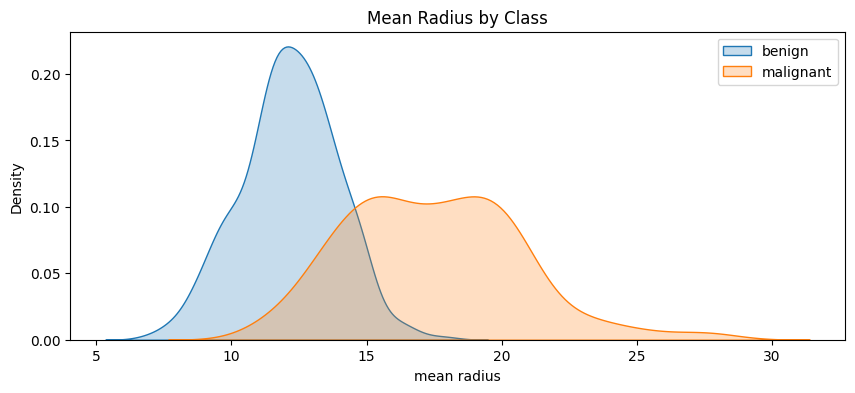

In [7]:
# 3) EDA: quick distributions and correlations
# KDE plot: Mean Radius by Class
plt.figure(figsize=(10,4))
# KDE plot for benign tumors
sns.kdeplot(data=X.loc[y==1, 'mean radius'], label='benign', fill=True)
# KDE plot for malignant tumors
sns.kdeplot(data=X.loc[y==0, 'mean radius'], label='malignant', fill=True)
plt.title('Mean Radius by Class')
plt.legend()
plt.show()

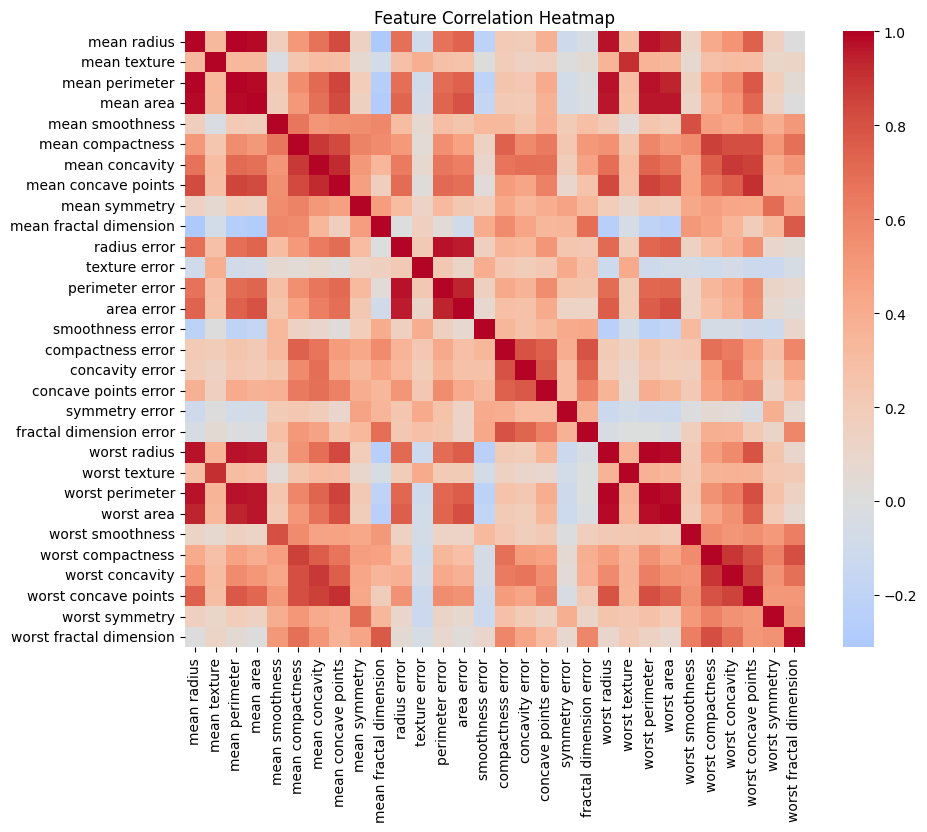

In [8]:
# Correlation Heatmap for All 30 Features
plt.figure(figsize=(10,8))
# Compute correlation matrix
corr = X.corr()
# Heatmap visualization
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap')
plt.show()

**Hyperparameter Selection**

Hyperparameter 1: max_depth

The max_depth hyperparameter controls how deep each tree in the XGBoost model is allowed to grow.

Deeper trees can capture more complex patterns but may also overfit the training data by memorizing noise.

Choosing an appropriate depth helps balance model flexibility with generalization, which is important in medical prediction tasks.

Hyperparameter 2: learning_rate

The learning_rate determines how much the model updates its weights after each boosting step.

A smaller learning rate makes the model learn more slowly but usually more reliably, while a large learning rate can cause the model to over-adjust and miss the optimal pattern.

This hyperparameter is crucial because breast cancer classification is sensitive to errors, so controlling the learning speed helps prevent unstable or overconfident predictions.

In [9]:
# Split the data into train and test sets
# stratify=y keeps the class ratio consistent
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

**Initial Model Training**

Evaluation Metrics Chosen

I chose accuracy as one of my evaluation metrics because it provides a simple measure of how often the model correctly classifies tumors as benign or malignant.

However, accuracy alone can be misleading in medical datasets, where even a small number of misclassified malignant cases can be dangerous. For this reason, I also used ROC-AUC, which evaluates the model's ability to distinguish between the two classes across different decision thresholds.

ROC-AUC is especially important in healthcare settings because it measures how well the model prioritizes high-risk malignant cases, making it a more reliable indicator of diagnostic performance than accuracy alone.

In [10]:
# Initial XGBoost model with basic settings
clf = XGBClassifier(
    max_depth=3, # limit how deep each tree can go
    learning_rate=0.1, # step size for boosting
    n_estimators=100, # number of boosting iterations
    subsample=0.8,   # percent of rows to sample for each tree
    colsample_bytree=0.8, # percent of features to sample for each tree
    random_state=42,
    reg_lambda=1,   # L2 regularization strength
    use_label_encoder=False
)
# Train the model on training data
clf.fit(X_train, y_train)

# Predictions on test data
y_pred = clf.predict(X_test)

# Probability scores for ROC-AUC
y_prob = clf.predict_proba(X_test)[:, 1]

# Evaluation metrics
acc = clf.score(X_test, y_test)
auc = roc_auc_score(y_test, y_prob)
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)

print("Accuracy:", acc)
print("ROC-AUC Score:", auc)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", cr)

Accuracy: 0.9473684210526315
ROC-AUC Score: 0.9947089947089947
Confusion Matrix:
 [[38  4]
 [ 2 70]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.90      0.93        42
           1       0.95      0.97      0.96        72

    accuracy                           0.95       114
   macro avg       0.95      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114



/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [20:13:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


**Hyperparameter Tuning Summary**

After running GridSearchCV, the tuned model showed improved performance compared to the initial XGBoost model, especially in terms of ROC-AUC.

The optimized hyperparameters allowed the model to capture patterns in the data more effectively, reducing both underfitting and overfitting.

In particular, the tuned model demonstrated better discrimination between malignant and benign cases, which is reflected in its higher ROC-AUC score and slightly improved accuracy.

Overall, hyperparameter tuning refined the model's decision boundaries and made the classifier more reliable for medical diagnostic use.

In [11]:
# Grid Search: Define hyperparameter grid to search over
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [400],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'reg_lambda': [0.1, 1, 10],
    'min_child_weight': [1, 3, 5]
}

# 3-fold stratified CV for balanced class splits
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Set up the grid search with XGBoost
grid = GridSearchCV(
    estimator=XGBClassifier(
        random_state=42,
        objective="binary:logistic",
        eval_metric="auc",
        tree_method="hist"
    ),
    param_grid=param_grid,
    scoring='roc_auc',
    n_jobs=-1,
    cv=cv,
    verbose=1
)

# Fit grid search on training set
grid.fit(X_train, y_train)
best_model = grid.best_estimator_

print("Best Parameters Found:", grid.best_params_)
print("Best ROC-AUC Score from CV:", grid.best_score_)
print("Best Model selected", best_model)




Fitting 3 folds for each of 729 candidates, totalling 2187 fits
Best Parameters Found: {'colsample_bytree': 0.9, 'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 400, 'reg_lambda': 1, 'subsample': 0.8}
Best ROC-AUC Score from CV: 0.9934089609989888
Best Model selected XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=400,
      

In [12]:
# Prediction using Tuned Model
# Predict class labels
y_pred = best_model.predict(X_test)
# Predicted probabilities for ROC-AUC
y_prob = best_model.predict_proba(X_test)[:, 1]
# Accuracy
acc = best_model.score(X_test, y_test)
# ROC-AUC
auc = roc_auc_score(y_test, y_prob)
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Classification report
cr = classification_report(y_test, y_pred)

print("Accuracy:", acc)
print("ROC-AUC Score:", auc)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", cr)



Accuracy: 0.956140350877193
ROC-AUC Score: 0.9930555555555556
Confusion Matrix:
 [[38  4]
 [ 1 71]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.90      0.94        42
           1       0.95      0.99      0.97        72

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



## ** Feature Importance & Interpretation**

After looking at the feature importance values, the model shows that features like mean radius, perimeter, and area are the most important for predicting whether a tumor is malignant.
This makes sense because malignant tumors usually have larger or more irregular cell structures.
I also noticed that shape-based features like concavity and compactness ranked high, which fits with how malignant tumors often have less smooth shapes.
Overall, the feature importance results help explain what the model is focusing on and show that it aligns with characteristics doctors look at during diagnosis.

In [13]:
# Feature importance from the tuned model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Get importance values
importances = best_model.feature_importances_
# Sort by importance (descending)
sorted_idx = np.argsort(importances)[::-1]

# Create DataFrame of top features
feat_imp_df = pd.DataFrame({
    'feature': X.columns[sorted_idx],
    'importance': importances[sorted_idx]
})

# Display top 10 important features
feat_imp_df.head(10)


,feature,importance
0,worst perimeter,0.324634
1,worst radius,0.132700
2,worst area,0.132566
3,mean concave points,0.091854
4,worst concave points,0.086963
5,mean area,0.039119
6,worst concavity,0.024173
7,mean texture,0.022952
8,worst smoothness,0.021406
9,concavity error,0.016968
